In [1]:
# install docplex pandas matplotlib
from docplex.mp.model import Model
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
# Import Data from Excel file
excel_file = "garden_capstone_data.xlsx"
plant_data = pd.ExcelFile(excel_file)

qty_req = pd.read_excel(plant_data, 'Quantity Requirements')
garden_layout = pd.read_excel(plant_data, 'Garden Layout')

qty_req = qty_req.drop(columns = ['Plant Height', 'Planting Depth'])
garden_layout = garden_layout.drop(columns = ['Unnamed: 3', 'Notes:'])

In [3]:
# Separating out minimum space between plants and converting to area.
temp_col = qty_req["Spacing Between Plants"].astype(str)

def revise_spacing(text):
    numbers = re.findall(r'\d+\.?\d*', text)
    if numbers:
        return float(numbers[0])
    else:
        return None

qty_req["Spacing Area (Inches)"] = temp_col.apply(revise_spacing) ** 2
qty_req = qty_req.drop(columns = ["Spacing Between Plants"])


# Setting up the size of the garden beds
garden_layout["Area (sq. inches)"] = garden_layout["Length"] * garden_layout["Width"] * 144

In [4]:
# Objective Function
def objective_function(glm, x, qty_req, bed_names):
    plant_areas = dict(zip(qty_req["Revised Names"], qty_req["Spacing Area (Inches)"]))
    total_area_used = glm.sum(x[plant, bed] * plant_areas[plant]
                              for (plant, bed) in x.keys())
    glm.maximize(total_area_used)


In [5]:
# Decision Variables
def plant_dec_var(glm, plant_names, bed_names):
    x = {}
    count = 0
    
    for index, row in qty_req.iterrows():
        if row["Plant in 2025"] == "Yes":
            plant = row["Revised Names"]
            for bed in bed_names:
                x[(plant, bed)] = glm.integer_var(name = f"x_{plant}_{bed}")  
                count += 1
    return x, count

In [6]:
# --------------------------------------------------------------
# Constraints
# 1. For all plants, are they to be planted in Current Year?
def planned_plants(glm, qty_req, bed_names, x):
    added, skipped = 0, 0
    for index, row in qty_req.iterrows():
        plant_name = row["Revised Names"]
        plant_in_2025 = row.get("Plant in 2025", "No")

        if plant_in_2025 == "Yes":
            if (plant_name, bed_names[0]) not in x:
                skipped += 1
                continue
            glm.add_constraint(
                glm.sum(x[plant_name, bed] for bed in bed_names) >= 1,
                ctname=f"plant_in_2025_{plant_name}"
            )
            added += 1
    return added, skipped  

In [7]:
# 2. The Area of Each Garden Bed Constraints
def garden_bed_area(glm, qty_req, garden_layout, x):
    added, skipped = 0, 0
    plant_areas = dict(zip(qty_req["Revised Names"], qty_req["Spacing Area (Inches)"]))
    bed_areas = dict(zip(garden_layout["Garden Beds"], garden_layout["Area (sq. inches)"]))

    x_plants = set(plant for plant, index in x.keys())
    
    for bed in bed_areas: 
        glm.add_constraint(glm.sum(x[plant, bed] * plant_areas[plant] \
                    for plant in x_plants) <= bed_areas[bed], \
                    ctname = f"bed_capacity_{bed}")
        added += 1
    return added, skipped


In [8]:
# 3. Minimum Plant (to be Planted) Quantity Constraints
def min_required(glm, qty_req, bed_names, x):
    added, skipped = 0, 0
    for index, row in qty_req.iterrows():
        plant = row["Revised Names"]       
        if pd.notna(row.get("Min Required")):
            if (plant, bed_names[0]) not in x:
                skipped += 1
                continue
            min_qty = row["Min Required"]
            glm.add_constraint(glm.sum(x[plant, bed] for bed in bed_names) >= min_qty, \
                                ctname=f"min_qty_{plant}")
            added += 1     
    return added, skipped

In [9]:
# 4. Maximum Plant (to be Planted) Quantity Constraints
def max_required(glm, qty_req, bed_names, x):
    added, skipped = 0, 0
    for index, row in qty_req.iterrows():
        plant = row["Revised Names"]
        if pd.notna(row.get("Max Required")):
            if (plant, bed_names[0]) not in x:
                skipped += 1
                continue
            max_qty = row["Max Required"]
            glm.add_constraint(glm.sum(x[plant, bed] for bed in bed_names) <= max_qty, \
                               ctname=f"max_qty_{plant}")
            added += 1
    return added, skipped


In [10]:
# 5. Exact Plant (to be planted) Quantity Constraints
def exact_required(glm, qty_req, bed_names, x):
    added, skipped = 0, 0
    for _, row in qty_req.iterrows():
        plant = row["Revised Names"]
        exact_qty = row.get("Exact Required")
        if pd.notna(exact_qty):
            if (plant, bed_names[0]) not in x:
                skipped += 1
                continue
            glm.add_constraint(
                glm.sum(x[plant, bed] for bed in bed_names) == exact_qty,
                ctname=f"exact_qty_{plant}"
            )
            added += 1
    return added, skipped


In [11]:
# 6. For specific plants where there has to be only one planted in EACH bed.
def one_per_bed(glm, qty_req, bed_names, x):
    added, skipped = 0, 0
    for index, row in qty_req.iterrows():
        if row.get("One per bed?") == "Yes":
            plant = row["Revised Names"]
            if (plant, bed_names[0]) not in x:
                skipped += len(bed_names)
                continue
            for bed in bed_names:
                glm.add_constraint(x[plant, bed] == 1, ctname=f"one_per_bed_{plant}_{bed}")
                added += 1
    return added, skipped

In [12]:
# 7. For specific plants where all of that plant needs to be planted in the SAME bed.
def all_in_one_bed(glm, qty_req, bed_names, x):
    added, skipped = 0, 0
    for index, row in qty_req.iterrows():
        if row.get("All in one bed?") == "Yes":
            plant = row["Revised Names"]
            if (plant, bed_names[0]) not in x:
                skipped += len(bed_names) + 1
                continue
                
            # Binary vars to track where the plant is placed
            y = {bed: glm.binary_var(name=f"y_{plant}_{bed}") for bed in bed_names}
            big_m = row["Exact Required"]  # or a large constant

            for bed in bed_names:
                glm.add_constraint(x[plant, bed] <= big_m * y[bed], \
                                   ctname=f"link_{plant}_{bed}")
                added += 1

            glm.add_constraint(glm.sum(y[bed] for bed in bed_names) == 1, \
                               ctname=f"only_one_bed_{plant}")
            added += 1
    return added, skipped

In [13]:
# 8. All beds must be used for planting this year
def use_all_beds(glm, x, bed_names):
    added = 0
    for bed in bed_names:
        glm.add_constraint(glm.sum(x[plant, b] for (plant, b) in x if b == bed)\
                               >= 1, ctname=f"use_bed_{bed}")
        added += 1
    return added


In [14]:
# Solving the Model
def solve_model(glm, x, qty_req, garden_layout):
    
    solution = glm.solve()
    
    if not solution:
        print("\n❌ No feasible solution found.")
        return

    print("\n🌿 Bed Area Usage Summary:\n")
    plant_areas = dict(zip(qty_req["Revised Names"], qty_req["Spacing Area (Inches)"]))
    bed_areas = dict(zip(garden_layout["Garden Beds"], garden_layout["Area (sq. inches)"]))

    for bed in garden_layout["Garden Beds"]:
        used_area = sum(
            plant_areas[plant] * x[plant, bed].solution_value
            for plant in qty_req["Revised Names"]
            if (plant, bed) in x
        )
        remaining_area = bed_areas[bed] - used_area
        print(f"🛏️ Bed {bed}:")
        print(f"   - Used Area     : {used_area:.1f} in²")
        print(f"   - Remaining Area: {remaining_area:.1f} in²\n")

    print("🥕 Plant Counts per Bed:\n")
    for bed in garden_layout["Garden Beds"]:
        print(f"🛏️ Bed {bed}:")
        for plant in qty_req["Revised Names"]:
            if (plant, bed) in x:
                count = int(x[plant, bed].solution_value)
                if count > 0:
                    print(f"   - {plant}: {count}")
        print()

    return solution

In [15]:
# Visualize the Layout
def visualize_layout(x, qty_req, garden_layout, bed_length=96, bed_width=48, spacing=2):
    plant_areas = dict(zip(qty_req["Revised Names"], qty_req["Spacing Area (Inches)"]))
    bed_names = list(garden_layout["Garden Beds"])
    plant_names = list(qty_req["Revised Names"])

    layout_data = {bed: [] for bed in bed_names}
    positions = {bed: [] for bed in bed_names}

    for bed in bed_names:
        x_pos = 0
        y_pos = 0
        row_height = 0

        for plant in plant_names:
            if (plant, bed) not in x:
                continue
            qty = int(x[plant, bed].solution_value)
            size = plant_areas[plant]
            for _ in range(qty):
                if x_pos + size > bed_length:
                    x_pos = 0
                    y_pos += row_height + spacing
                    row_height = 0
                if y_pos + size > bed_width:
                    break
                layout_data[bed].append(plant)
                positions[bed].append((x_pos, y_pos, size))
                x_pos += size + spacing
                row_height = max(row_height, size)

    fig, axes = plt.subplots(1, len(bed_names), figsize=(5 * len(bed_names), 5))
    if len(bed_names) == 1:
        axes = [axes]

    for idx, bed in enumerate(bed_names):
        ax = axes[idx]
        ax.set_xlim(0, bed_length)
        ax.set_ylim(0, bed_width)
        ax.set_title(f"Bed {bed}")
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_facecolor("#e6ffe6")

        for k, (x0, y0, size) in enumerate(positions[bed]):
            ax.add_patch(plt.Rectangle((x0, y0), size, size, edgecolor='black', facecolor='lightgreen'))
            ax.text(x0 + size / 2, y0 + size / 2,
                    layout_data[bed][k][:3].upper(), ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

In [16]:
# Final Report of the plants used overall
def report_plant_counts(x, qty_req, garden_layout):
    plant_names = list(qty_req["Revised Names"])
    bed_names = list(garden_layout["Garden Beds"])

    total_counts = []
    for plant in plant_names:
        total = sum(int(x[plant, bed].solution_value) for bed in bed_names if (plant, bed) in x)
        if total > 0:
            total_counts.append((plant, total))

    total_counts.sort(key=lambda x: x[1], reverse=True)

    print("📊 Total Quantity of Each Plant Across All Beds:\n")
    for name, total in total_counts:
        print(f"   - {name}: {total}")



Total decision variables: 44
Total Constraints Added: 47
Total Constraints Skipped: 0
Total model components: 91

🌿 Bed Area Usage Summary:

🛏️ Bed A:
   - Used Area     : 4608.0 in²
   - Remaining Area: 0.0 in²

🛏️ Bed B:
   - Used Area     : 4608.0 in²
   - Remaining Area: 0.0 in²

🛏️ Bed C:
   - Used Area     : 4603.0 in²
   - Remaining Area: 5.0 in²

🛏️ Bed D:
   - Used Area     : 4608.0 in²
   - Remaining Area: 0.0 in²

🥕 Plant Counts per Bed:

🛏️ Bed A:
   - Bell Pepper: 11
   - Jalapeno: 11
   - Lavendar, English: 1
   - Spearmint: 4

🛏️ Bed B:
   - Bell Pepper: 4
   - Lavendar, English: 1
   - Tomato, Cherry: 12

🛏️ Bed C:
   - Lavendar, English: 1
   - Lettuce, Romaine: 4
   - Onion, Bunching: 71
   - Parsley, Italian: 4
   - Spearmint: 1
   - Tomato, Beefsteak: 2
   - Zucchini: 4

🛏️ Bed D:
   - Bell Pepper: 1
   - Lavendar, English: 1
   - Onion, Yellow: 120
   - Spearmint: 10



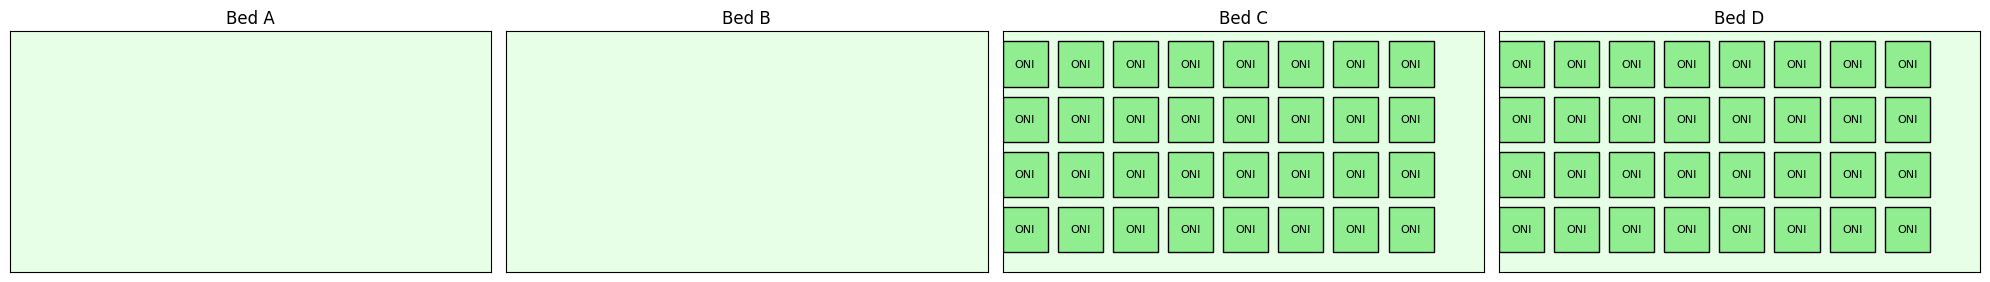

📊 Total Quantity of Each Plant Across All Beds:

   - Onion, Yellow: 120
   - Onion, Bunching: 71
   - Bell Pepper: 16
   - Spearmint: 15
   - Tomato, Cherry: 12
   - Jalapeno: 11
   - Lavendar, English: 4
   - Lettuce, Romaine: 4
   - Parsley, Italian: 4
   - Zucchini: 4
   - Tomato, Beefsteak: 2


In [17]:
# Main Execution Block
if __name__ == "__main__":
    # Create Model Environment
    glm = Model(name = "Garden Layout Model")

    # These are the plants that are listed as to be planted in the current year
    plant_names = list(qty_req["Revised Names"])
    bed_names = list(garden_layout["Garden Beds"])
    
    # --------------------------------------------------------------
    # Create Decision Variables
    var_count = 0
    x, var_count = plant_dec_var(glm, plant_names, bed_names)
    
    
    # --------------------------------------------------------------
    # Constraints
    constraint_count = 0
    constraint_skipped = 0
    
    # 1. For all plants, are they to be planted in Current Year?
    added, skipped = planned_plants(glm, qty_req, bed_names, x)
    constraint_count += added
    constraint_skipped += skipped
    
    # 2. The Area of Each Garden Bed Constraints
    added, skipped = garden_bed_area(glm, qty_req, garden_layout, x)
    constraint_count += added
    constraint_skipped += skipped  
    
    # 3. Minimum Plant (to be Planted) Quantity Constraints
    added, skipped = min_required(glm, qty_req, bed_names, x)
    constraint_count += added
    constraint_skipped += skipped  
    
    # 4. Maximum Plant (to be Planted) Quantity Constraints
    added, skipped = max_required(glm, qty_req, bed_names, x)
    constraint_count += added
    constraint_skipped += skipped   
    
    # 5. Exact Plant (to be planted) Quantity Constraints
    added, skipped = exact_required(glm, qty_req, bed_names, x)    
    constraint_count += added
    constraint_skipped += skipped  
    
    # 6. For specific plants where there has to be only one planted in EACH bed.
    added, skipped = one_per_bed(glm, qty_req, bed_names, x)
    constraint_count += added
    constraint_skipped += skipped  
    
    # 7. For specific plants where all of that plant needs to be planted in the SAME bed.
    added, skipped = all_in_one_bed(glm, qty_req, bed_names, x)
    constraint_count += added
    constraint_skipped += skipped

    # 8. All beds must be used for planting this year
    added = use_all_beds(glm, x, bed_names)
    constraint_count += added
    
    print(f"\nTotal decision variables: {var_count}")
    print(f"Total Constraints Added: {constraint_count}")
    print(f"Total Constraints Skipped: {constraint_skipped}")
    print(f"Total model components: {constraint_count + var_count + constraint_skipped}")

    
    # --------------------------------------------------------------
    # Objective Function
    objective_function(glm, x, qty_req, bed_names)
    
    # Solve the model
    solution = solve_model(glm, x, qty_req, garden_layout)

    if solution:
        visualize_layout(x, qty_req, garden_layout)
        report_plant_counts(x, qty_req, garden_layout)
    else:
        print("❌ No feasible solution found.")

In [18]:
# pip install docplex pandas matplotlib
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model

# 1. Parse spacing ranges into (min, max)
def parse_spacing(txt):
    nums = list(map(float, re.findall(r'\d+\.?\d*', str(txt))))
    if not nums:
        raise ValueError(f"No numbers in '{txt}'")
    return min(nums), max(nums)

# 2. Load & normalize your sheets
def load_data(path="garden_capstone_data.xlsx"):
    qty    = pd.read_excel(path, sheet_name="Quantity Requirements")
    layout = pd.read_excel(path, sheet_name="Garden Layout")
    # rename columns to simple keys
    qty = qty.rename(columns={
      "Revised Names":"Plant",
      "Plant in 2025":"PlantThisYear",
      "Min Required":"MinReq",
      "Max Required":"MaxReq",
      "Exact Required":"ExactReq",
      "One per bed?":"OnePerBed",
      "All in one bed?":"AllInOneBed",
      "Spacing Between Plants":"Spacing"
    })
    # extract spacing ranges
    mins, maxs = zip(*(qty["Spacing"].map(parse_spacing)))
    qty["MinSp"], qty["MaxSp"] = mins, maxs
    # bed layout
    colmap = {}
    for c in layout.columns:
        lc = c.strip().lower()
        if "garden beds" in lc:    colmap[c] = "Bed"
        elif "length" in lc:        colmap[c] = "Length_ft"
        elif "width" in lc:         colmap[c] = "Width_ft"
    layout = layout.rename(columns=colmap)[["Bed","Length_ft","Width_ft"]]
    layout["BedArea"] = layout["Length_ft"] * layout["Width_ft"] * 144
    return qty, layout

# 3. Build model given a set of plant‐areas
def build_model(qty, layout, plant_area):
    mdl    = Model("Garden")
    plants = qty["Plant"].tolist()
    beds   = layout["Bed"].tolist()

    # decision vars
    x = mdl.integer_var_dict(((p,b) for p in plants for b in beds),
                              lb=0, name="x")

    # (a) only plant if yes
    for _,r in qty.iterrows():
        p   = r["Plant"]
        expr = mdl.sum(x[p,b] for b in beds)
        if str(r["PlantThisYear"]).strip().lower()=="yes":
            mdl.add_constraint(expr >= 1, f"plant_{p}")
        else:
            mdl.add_constraint(expr == 0, f"noplant_{p}")

    # (b) bed capacity
    for b in beds:
        cap = layout.loc[layout["Bed"]==b,"BedArea"].iat[0]
        mdl.add_constraint(
          mdl.sum(x[p,b]*plant_area[p] for p in plants) <= cap,
          f"cap_{b}"
        )

    # (c)/(d)/(e) min/max/exact
    for _,r in qty.iterrows():
        p     = r["Plant"]
        tot   = mdl.sum(x[p,b] for b in beds)
        if pd.notna(r["ExactReq"]):
            mdl.add_constraint(tot == int(r["ExactReq"]), f"exact_{p}")
        else:
            if pd.notna(r["MinReq"]):
                mdl.add_constraint(tot >= int(r["MinReq"]), f"min_{p}")
            if pd.notna(r["MaxReq"]):
                mdl.add_constraint(tot <= int(r["MaxReq"]), f"max_{p}")

    # (f) one per bed
    for _,r in qty.iterrows():
        if str(r["OnePerBed"]).strip().lower().startswith("y"):
            p = r["Plant"]
            for b in beds:
                mdl.add_constraint(x[p,b]==1, f"one_{p}_{b}")

    # (g) all in one bed
    bigM = int(qty["MaxReq"].max(skipna=True) or len(beds)*5)
    for _,r in qty.iterrows():
        if str(r["AllInOneBed"]).strip().lower().startswith("y"):
            p = r["Plant"]
            z = mdl.binary_var_dict(beds, name=f"z_{p}")
            for b in beds:
                mdl.add_constraint(x[p,b] <= bigM*z[b], f"group_{p}_{b}")
            mdl.add_constraint(mdl.sum(z[b] for b in beds)==1, f"onebed_{p}")

    # (h) all beds used
    for b in beds:
        mdl.add_constraint(mdl.sum(x[p,b] for p in plants)>=1, f"usebed_{b}")

    # objective = fill area
    total = mdl.sum(x[p,b]*plant_area[p] for p in plants for b in beds)
    mdl.maximize(total)
    return mdl, x

# 4. Iterative solve: scale min-spacing up until infeasible
def find_max_spacing(qty, layout, step_ratio=0.1):
    # build min-spacing areas
    min_sp = qty["MinSp"].values
    max_sp = qty["MaxSp"].values
    # global ratio limit so no plant exceeds its max
    ratio_limit = np.min(max_sp / min_sp)
    best_ratio  = 1.0
    best_x      = None

    ratio = 1.0
    while ratio <= ratio_limit + 1e-6:
        # compute plant_area at this ratio
        plant_area = dict(zip(
            qty["Plant"],
            (qty["MinSp"] * ratio)**2
        ))
        mdl, x = build_model(qty, layout, plant_area)
        sol = mdl.solve(log_output=False)
        if not sol:
            break
        best_ratio = ratio
        best_x     = (model := mdl), x
        ratio += step_ratio

    return best_ratio, best_x

# 5. Report the final solution
def report_solution(qty, layout, solved, x, ratio):
    mdl = solved
    plants = qty["Plant"].tolist()
    beds   = layout["Bed"].tolist()
    area   = {p:(qty.loc[qty["Plant"]==p,"MinSp"].iat[0]*ratio)**2 for p in plants}

    print(f"\n✅ Feasible up to spacing ratio = {ratio:.2f}")
    print("📊 Bed usage at that spacing:")
    for b in beds:
        used = sum(x[p,b].solution_value * area[p] for p in plants)
        cap  = layout.loc[layout["Bed"]==b,"BedArea"].iat[0]
        print(f" • Bed {b}: {used:.0f}/{cap:.0f} in²")

    print("\n🌿 Plant counts:")
    df = pd.DataFrame([
        {b:int(x[p,b].solution_value) for b in beds}
        for p in plants
    ], index=plants)
    df["Total"] = df.sum(axis=1)
    display(df.sort_values("Total", ascending=False))

    # optional: layout visual
    # … your matplotlib code here …

# 6. Main
if __name__=="__main__":
    qty, layout = load_data()
    ratio, best = find_max_spacing(qty, layout, step_ratio=0.1)
    if best is None:
        print("❌ Infeasible even at minimum spacing!")
    else:
        mdl, x = best
        report_solution(qty, layout, mdl, x, ratio)



✅ Feasible up to spacing ratio = 1.00
📊 Bed usage at that spacing:
 • Bed A: 4608/4608 in²
 • Bed B: 4608/4608 in²
 • Bed C: 4603/4608 in²
 • Bed D: 4608/4608 in²

🌿 Plant counts:


,A,B,C,D,Total
"Onion, Yellow",0,0,104,16,120
"Onion, Bunching",0,0,19,0,19
Bell Pepper,1,12,0,3,16
"Tomato, Cherry",3,1,0,12,16
Jalapeno,12,0,0,0,12
Spearmint,5,1,2,0,8
"Tomato, Beefsteak",0,6,0,0,6
"Lavendar, English",1,1,1,1,4
"Lettuce, Romaine",0,0,4,0,4
"Parsley, Italian",0,4,0,0,4


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Prepare your data from memory ---
beds   = layout.index.tolist()            # Bed names, e.g. ['A','B','C','D']
plants = qty["Plant"].tolist()            # Plant names

# Reconstruct counts DataFrame
result = { (p,b): int(x[p,b].solution_value) for p in plants for b in beds }
import pandas as pd
df_counts = pd.DataFrame(
    [[ result[p,b] for b in beds ] for p in plants],
    index=plants, columns=beds
)

# Plant footprint map (in²) from your qty DataFrame
if "PlantArea" in qty.columns:
    plant_area = dict(zip(qty["Plant"], qty["PlantArea"]))
else:
    plant_area = dict(zip(qty["Plant"], qty["Area_in2"]))

# Bed dimensions in inches
bed_w = (layout["Length_ft"] * 12).to_dict()
bed_h = (layout["Width_ft"]  * 12).to_dict()

# --- 2) Tile-based plot per bed ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
colors = plt.cm.Set3.colors

for ax, b in zip(axes, beds):
    W = bed_w[b]; H = bed_h[b]
    ax.set_xlim(0, W); ax.set_ylim(0, H)
    ax.set_aspect("equal"); ax.axis("off")
    ax.set_title(f"Bed {b}  ({int(W)}″×{int(H)}″)", fontsize=14)
    
    x0 = 0
    y0 = 0
    row_h = 0
    
    # iterate plants in a fixed order
    for j, p in enumerate(plants):
        count = df_counts.at[p, b]
        if count <= 0:
            continue
        size = np.sqrt(plant_area[p])
        for _ in range(count):
            # wrap to next row if needed
            if x0 + size > W:
                x0 = 0
                y0 += row_h
                row_h = 0
            # draw the square
            rect = plt.Rectangle(
                (x0, y0), size, size,
                facecolor=colors[j % len(colors)],
                edgecolor="white", linewidth=0.5
            )
            ax.add_patch(rect)
            # label with 3-letter code
            ax.text(
                x0 + size/2, y0 + size/2,
                p.split()[0][:3].upper(),
                ha="center", va="center",
                fontsize=7, color="black"
            )
            x0 += size
            row_h = max(row_h, size)

plt.tight_layout()
plt.savefig("bed_tile_layout.png", dpi=200)
plt.show()


KeyError: ('Bell Pepper', 0)